In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import spacy
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
df = pd.read_csv("fake_job_postings.csv")
print(df.head())
print(df.dtypes)
print(df.isnull().sum())

   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

In [3]:
columns = ['department','salary_range','job_id']
for col in columns:
    del df[col]
df.fillna('',inplace=True)

In [4]:
print(df)
print(df.isnull().sum())
print(df.describe())

                                                   title  \
0                                       Marketing Intern   
1              Customer Service - Cloud Video Production   
2                Commissioning Machinery Assistant (CMA)   
3                      Account Executive - Washington DC   
4                                    Bill Review Manager   
...                                                  ...   
17875                   Account Director - Distribution    
17876                                 Payroll Accountant   
17877  Project Cost Control Staff Engineer - Cost Con...   
17878                                   Graphic Designer   
17879                         Web Application Developers   

                   location  \
0          US, NY, New York   
1            NZ, , Auckland   
2             US, IA, Wever   
3        US, DC, Washington   
4        US, FL, Fort Worth   
...                     ...   
17875       CA, ON, Toronto   
17876  US, PA, Philadelphia   


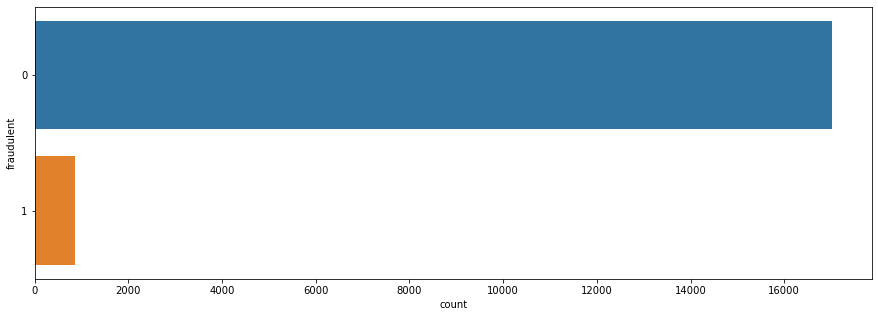

In [5]:
plt.figure(figsize=(15,5))
sb.countplot(y='fraudulent',data = df)
plt.show()

In [6]:
df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [7]:
experience = dict(df.required_experience.value_counts())
del experience['']
experience

{'Mid-Senior level': 3809,
 'Entry level': 2697,
 'Associate': 2297,
 'Not Applicable': 1116,
 'Director': 389,
 'Internship': 381,
 'Executive': 141}

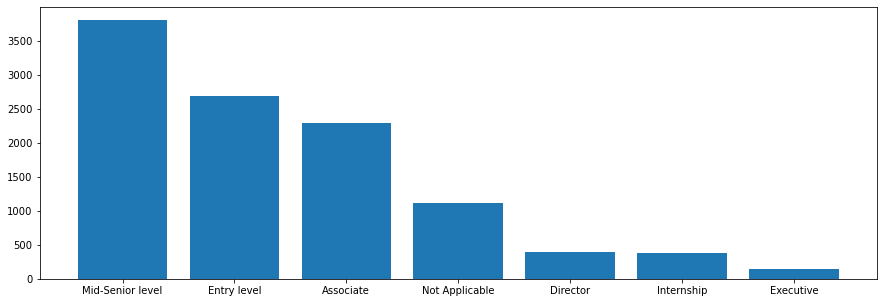

In [8]:
plt.figure(figsize=(15,5))
plt.bar(experience.keys(),experience.values())
plt.show()

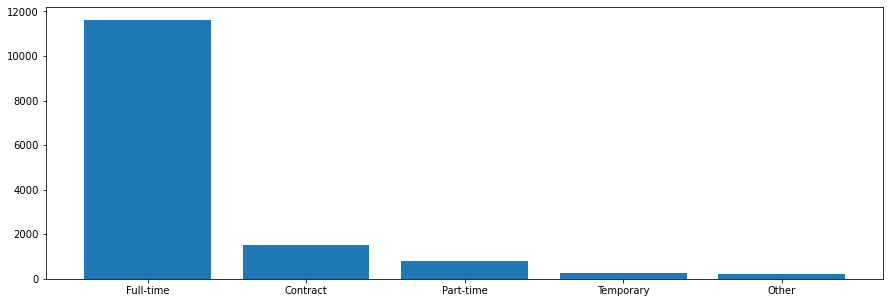

In [9]:
emp_type = dict(df.employment_type.value_counts())
del emp_type['']
plt.figure(figsize=(15,5))
plt.bar(emp_type.keys(),emp_type.values())
plt.show()

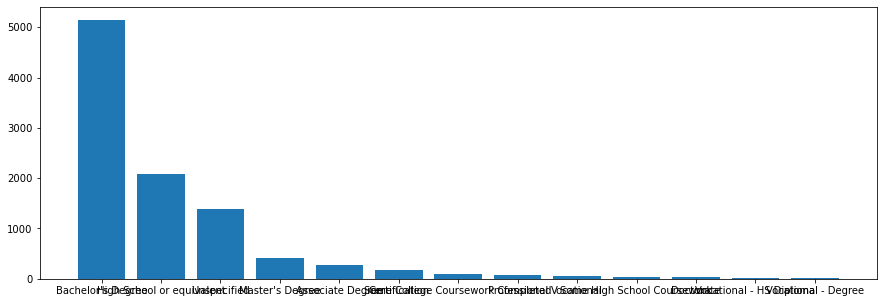

In [10]:
education = dict(df.required_education.value_counts())
del education['']
plt.figure(figsize=(15,5))
plt.bar(education.keys(),education.values())
plt.show()

In [11]:
df['text']=df['title']+df['company_profile']+df['description']+df['requirements']+df['benefits']

In [12]:
df['text']

0        Marketing InternWe're Food52, and we've create...
1        Customer Service - Cloud Video Production90 Se...
2        Commissioning Machinery Assistant (CMA)Valor S...
3        Account Executive - Washington DCOur passion f...
4        Bill Review ManagerSpotSource Solutions LLC is...
                               ...                        
17875    Account Director - Distribution Vend is lookin...
17876    Payroll AccountantWebLinc is the e-commerce pl...
17877    Project Cost Control Staff Engineer - Cost Con...
17878    Graphic DesignerNemsia Studios is looking for ...
17879    Web Application DevelopersVend is looking for ...
Name: text, Length: 17880, dtype: object

In [13]:
dftemp = df.copy(deep=True)
dftemp

,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,"Marketing InternWe're Food52, and we've create..."
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,Customer Service - Cloud Video Production90 Se...
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,Commissioning Machinery Assistant (CMA)Valor S...
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,Account Executive - Washington DCOur passion f...
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,Bill Review ManagerSpotSource Solutions LLC is...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,,Computer Software,Sales,0,Account Director - Distribution Vend is lookin...
17876,Payroll Accountant,"US, PA, Philadelphia",WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,Payroll AccountantWebLinc is the e-commerce pl...
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,,,,,0,Project Cost Control Staff Engineer - Cost Con...
17878,Graphic Designer,"NG, LA, Lagos",,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,Graphic DesignerNemsia Studios is looking for ...


In [14]:
dftemp.drop(df.iloc[:,:-2], inplace = True, axis = 1)
dftemp

,fraudulent,text
0,0,"Marketing InternWe're Food52, and we've create..."
1,0,Customer Service - Cloud Video Production90 Se...
2,0,Commissioning Machinery Assistant (CMA)Valor S...
3,0,Account Executive - Washington DCOur passion f...
4,0,Bill Review ManagerSpotSource Solutions LLC is...
...,...,...
17875,0,Account Director - Distribution Vend is lookin...
17876,0,Payroll AccountantWebLinc is the e-commerce pl...
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,Graphic DesignerNemsia Studios is looking for ...


In [15]:
columns = ['title','company_profile','description','requirements','benefits','text']
for col in columns:
    del df[col]

In [16]:
df

,location,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,"US, NY, New York",0,1,0,Other,Internship,,,Marketing,0
1,"NZ, , Auckland",0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,"US, IA, Wever",0,1,0,,,,,,0
3,"US, DC, Washington",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,"US, FL, Fort Worth",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...
17875,"CA, ON, Toronto",0,1,1,Full-time,Mid-Senior level,,Computer Software,Sales,0
17876,"US, PA, Philadelphia",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,"US, TX, Houston",0,0,0,Full-time,,,,,0
17878,"NG, LA, Lagos",0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [17]:
fraud_text = dftemp[dftemp.fraudulent==1].text
real_text = dftemp[dftemp.fraudulent==0].text

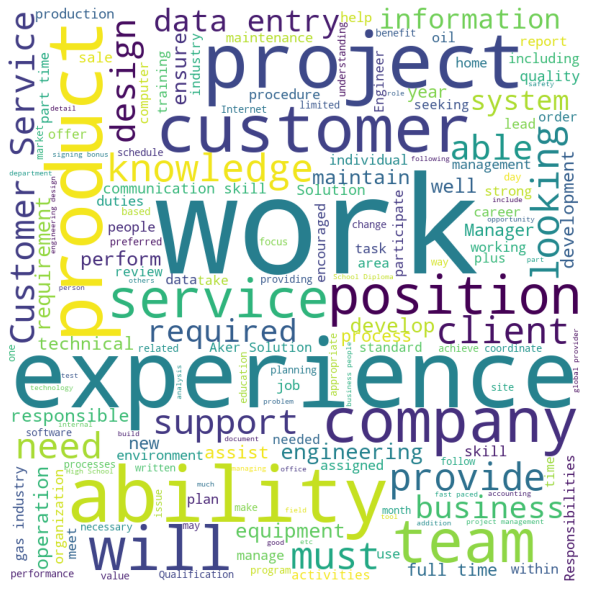

In [18]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(str(" ".join(fraud_text)))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

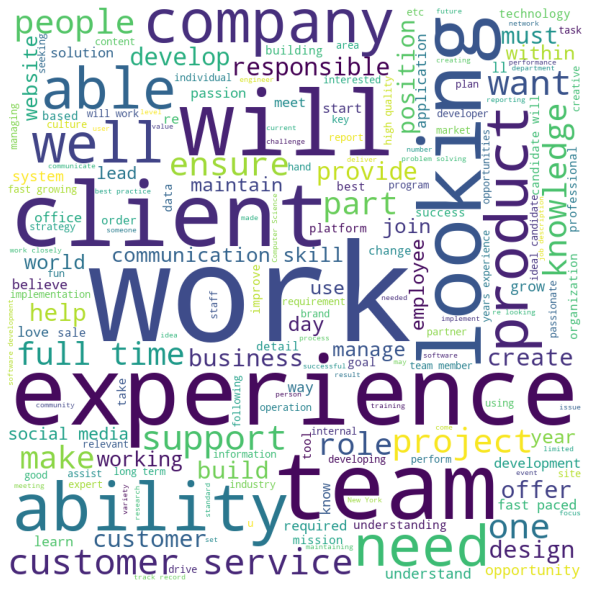

In [19]:
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords,min_font_size = 10).generate(str(" ".join(real_text)))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [20]:
def clean_text(text):
    return text.strip().lower()

In [21]:
def remove_special_characters(text):
    char = r'[^A-z0-9\s]'
    possessive_char = r'\ss\s'
    white_space=r'  '
    text = re.sub(char, '', text) #removing
    text = re.sub(possessive_char,'',text)
    text = re.sub(white_space,' ',text)
    return text

In [22]:
i=0
lemmatizer = WordNetLemmatizer()
for text in dftemp['text']:
    texts = clean_text(text)
    texts = remove_special_characters(texts)
    word_tokens = word_tokenize(texts)
    filtered_sentence = ''
    for w in word_tokens:
        if w not in stopwords:
            wo = lemmatizer.lemmatize(w)
            filtered_sentence+= wo+' '
    dftemp['text'][i] = filtered_sentence
    i+= 1

<ipython-input-22-41afe9649251>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftemp['text'][i] = filtered_sentence


In [23]:
dftemp

,fraudulent,text
0,0,marketing internwere food52 weve created groun...
1,0,customer service cloud video production90 seco...
2,0,commissioning machinery assistant cmavalor ser...
3,0,account executive washington dcour passion imp...
4,0,bill review managerspotsource solution llc glo...
...,...,...
17875,0,account director distribution vend looking awe...
17876,0,payroll accountantweblinc ecommerce platform s...
17877,0,project cost control staff engineer cost contr...
17878,0,graphic designernemsia studio looking experien...


In [24]:
dftemp['text']

0        marketing internwere food52 weve created groun...
1        customer service cloud video production90 seco...
2        commissioning machinery assistant cmavalor ser...
3        account executive washington dcour passion imp...
4        bill review managerspotsource solution llc glo...
                               ...                        
17875    account director distribution vend looking awe...
17876    payroll accountantweblinc ecommerce platform s...
17877    project cost control staff engineer cost contr...
17878    graphic designernemsia studio looking experien...
17879    web application developersvend looking awesome...
Name: text, Length: 17880, dtype: object

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer(max_features = 500)
vectorizer.fit(dftemp['text'])
X = vectorizer.transform(dftemp['text'])

In [26]:
X

<17880x500 sparse matrix of type '<class 'numpy.float64'>'
	with 1339411 stored elements in Compressed Sparse Row format>

In [27]:
df1 = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
dftemp.drop(['text'], axis = 1, inplace = True)
dftemp = pd.concat([df1,dftemp], axis =1)

In [28]:
#print(df.dtypes)
dftemp.head()

,ability,able,abroad,access,account,accounting,achieve,across,activity,advertising,...,word,work,working,world,writing,written,year,youll,youre,fraudulent
0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.064965,0.087753,0.000000,0.0,0.000000,0.000000,0.0,0.0,0
1,0.000000,0.016694,0.0,0.0,0.021551,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.027948,0.075502,0.166842,0.0,0.000000,0.000000,0.0,0.0,0
2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.076230,0.354937,0.0,...,0.098559,0.078377,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0
3,0.030213,0.000000,0.0,0.0,0.493356,0.0,0.048676,0.000000,0.000000,0.0,...,0.000000,0.058163,0.000000,0.138888,0.0,0.036099,0.045423,0.0,0.0,0
4,0.000000,0.043432,0.0,0.0,0.000000,0.0,0.000000,0.047146,0.000000,0.0,...,0.000000,0.048475,0.032739,0.000000,0.0,0.000000,0.028393,0.0,0.0,0


In [29]:
for i in range(len(df['location'])):
    a = df['location'][i].split(',')
    df['location'][i] = a[0]

<ipython-input-29-b61ab4b6108a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['location'][i] = a[0]


In [30]:
df['location'].unique()

array(['US', 'NZ', 'DE', 'GB', 'AU', 'SG', 'IL', 'AE', 'CA', 'IN', 'EG',
       'PL', 'GR', '', 'PK', 'BE', 'BR', 'SA', 'DK', 'RU', 'ZA', 'CY',
       'HK', 'TR', 'IE', 'LT', 'JP', 'NL', 'AT', 'KR', 'FR', 'EE', 'TH',
       'PA', 'KE', 'MU', 'MX', 'RO', 'MY', 'FI', 'CN', 'ES', 'SE', 'CL',
       'UA', 'QA', 'IT', 'LV', 'IQ', 'BG', 'PH', 'CZ', 'VI', 'MT', 'HU',
       'BD', 'KW', 'LU', 'NG', 'RS', 'BY', 'VN', 'ID', 'ZM', 'NO', 'BH',
       'UG', 'CH', 'TT', 'SD', 'SK', 'AR', 'TW', 'PT', 'PE', 'CO', 'IS',
       'SI', 'MA', 'AM', 'TN', 'GH', 'AL', 'HR', 'CM', 'SV', 'NI', 'LK',
       'JM', 'KZ', 'KH'], dtype=object)

In [31]:
df['telecommuting'].unique()

array([0, 1], dtype=int64)

In [32]:
df['has_company_logo'].unique()

array([1, 0], dtype=int64)

In [33]:
df['industry'].unique()

array(['', 'Marketing and Advertising', 'Computer Software',
       'Hospital & Health Care', 'Online Media',
       'Information Technology and Services', 'Financial Services',
       'Management Consulting', 'Events Services', 'Internet',
       'Facilities Services', 'Consumer Electronics',
       'Telecommunications', 'Consumer Services', 'Construction',
       'Oil & Energy', 'Education Management', 'Building Materials',
       'Banking', 'Food & Beverages', 'Food Production',
       'Health, Wellness and Fitness', 'Insurance', 'E-Learning',
       'Cosmetics', 'Staffing and Recruiting',
       'Venture Capital & Private Equity', 'Leisure, Travel & Tourism',
       'Human Resources', 'Pharmaceuticals', 'Farming', 'Legal Services',
       'Luxury Goods & Jewelry', 'Machinery', 'Real Estate',
       'Mechanical or Industrial Engineering',
       'Public Relations and Communications', 'Consumer Goods',
       'Medical Practice', 'Electrical/Electronic Manufacturing',
       'Hospital

In [34]:
df['function'].unique()

array(['Marketing', 'Customer Service', '', 'Sales',
       'Health Care Provider', 'Management', 'Information Technology',
       'Other', 'Engineering', 'Administrative', 'Design', 'Production',
       'Education', 'Supply Chain', 'Business Development',
       'Product Management', 'Financial Analyst', 'Consulting',
       'Human Resources', 'Project Management', 'Manufacturing',
       'Public Relations', 'Strategy/Planning', 'Advertising', 'Finance',
       'General Business', 'Research', 'Accounting/Auditing',
       'Art/Creative', 'Quality Assurance', 'Data Analyst',
       'Business Analyst', 'Writing/Editing', 'Distribution', 'Science',
       'Training', 'Purchasing', 'Legal'], dtype=object)

In [35]:
mean_loc = df.groupby('location')['fraudulent'].mean()
df.loc[:,'location'] = df['location'].map(mean_loc)

In [36]:
mean_emp = df.groupby('employment_type')['fraudulent'].mean()
df.loc[:,'employment_type'] = df['employment_type'].map(mean_emp)

In [37]:
mean_exp = df.groupby('required_experience')['fraudulent'].mean()
df.loc[:,'required_experience'] = df['required_experience'].map(mean_exp)

In [38]:
mean_edu = df.groupby('required_education')['fraudulent'].mean()
df.loc[:,'required_education'] = df['required_education'].map(mean_edu)

In [39]:
mean_industry = df.groupby('industry')['fraudulent'].mean()
df.loc[:,'industry'] = df['industry'].map(mean_industry)

In [40]:
mean_function = df.groupby('function')['fraudulent'].mean()
df.loc[:,'function'] = df['function'].map(mean_function)

In [41]:
del df['fraudulent']
print(df.dtypes)
print(df.head())

location               float64
telecommuting            int64
has_company_logo         int64
has_questions            int64
employment_type        float64
required_experience    float64
required_education     float64
industry               float64
function               float64
dtype: object
   location  telecommuting  has_company_logo  has_questions  employment_type  \
0  0.068506              0                 1              0         0.066079   
1  0.000000              0                 1              0         0.042169   
2  0.068506              0                 1              0         0.069432   
3  0.068506              0                 1              0         0.042169   
4  0.068506              0                 1              1         0.042169   

   required_experience  required_education  industry  function  
0             0.026247            0.055645  0.056088  0.012048  
1             0.053763            0.055645  0.054348  0.054516  
2             0.061702         

In [42]:
df_main = pd.concat([df,dftemp], axis =1)
df_main.head()

,location,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,ability,...,word,work,working,world,writing,written,year,youll,youre,fraudulent
0,0.068506,0,1,0,0.066079,0.026247,0.055645,0.056088,0.012048,0.000000,...,0.000000,0.064965,0.087753,0.000000,0.0,0.000000,0.000000,0.0,0.0,0
1,0.000000,0,1,0,0.042169,0.053763,0.055645,0.054348,0.054516,0.000000,...,0.000000,0.027948,0.075502,0.166842,0.0,0.000000,0.000000,0.0,0.0,0
2,0.068506,0,1,0,0.069432,0.061702,0.055645,0.056088,0.052208,0.000000,...,0.098559,0.078377,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0
3,0.068506,0,1,0,0.042169,0.029667,0.019436,0.003634,0.027929,0.030213,...,0.000000,0.058163,0.000000,0.138888,0.0,0.036099,0.045423,0.0,0.0,0
4,0.068506,0,1,1,0.042169,0.029667,0.019436,0.102616,0.002959,0.000000,...,0.000000,0.048475,0.032739,0.000000,0.0,0.000000,0.028393,0.0,0.0,0


In [87]:
X = df_main.iloc[:,:-1]
Y = df_main.iloc[:,-1]

In [103]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25, random_state = 0)

In [104]:
weight = dict({0:1,1:50})

In [105]:
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy",class_weight=weight)
model = rfc.fit(X_train,Y_train)

In [106]:
pred = rfc.predict(X_test)
score = accuracy_score(Y_test, pred)
score

0.9796420581655481

In [107]:
print(classification_report(Y_test, pred))
print(confusion_matrix(Y_test, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4273
           1       0.95      0.57      0.71       197

    accuracy                           0.98      4470
   macro avg       0.96      0.78      0.85      4470
weighted avg       0.98      0.98      0.98      4470

[[4267    6]
 [  85  112]]
